# Convolutional networks for CIFAR10

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from skimage import color
from skimage import data
import math
import random

# Convert labels to one-hot vectors

# Convert classes to indicator vectors
def one_hot(values,n_values=10):
    n_v = np.maximum(n_values,np.max(values) + 1)
    oh=np.eye(n_v)[values]
    return oh

/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Get CIFAR10 data and split into train validation and test

In [3]:
def get_cifar():
    tr=np.float32(np.load('/project/cmsc25025/mnist/CIFAR_10.npy'))
    tr_lb=np.int32(np.load('/project/cmsc25025/mnist/CIFAR_labels.npy'))
    tr=tr.reshape((-1,np.prod(np.array(tr.shape)[1:4])))
    train_data=tr[0:45000]/255.
    train_labels=one_hot(tr_lb[0:45000])
    val_data=tr[45000:]/255.
    val_labels=one_hot(tr_lb[45000:])
    test_data=np.float32(np.load('/project/cmsc25025/mnist/CIFAR_10_test.npy'))
    test_data=test_data.reshape((-1,np.prod(np.array(test_data.shape)[1:4])))
    test_data=test_data/255.
    test_labels=one_hot(np.int32(np.load('/project/cmsc25025/mnist/CIFAR_labels_test.npy')))
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)

## (a) Read in the cifar data. Display some of the images.

In [4]:
train, val, test = get_cifar()

In [7]:
test[0].shape

(10000, 3072)

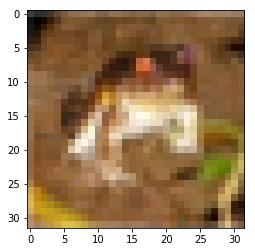

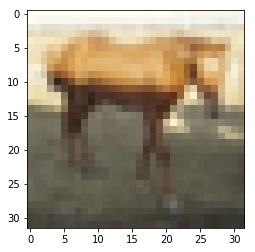

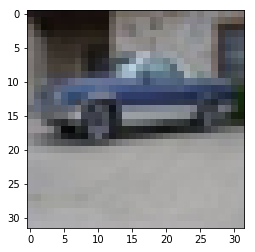

In [13]:
plt.imshow(train[0][0].reshape((32,32,3)), cmap = "gray")
plt.show()
plt.imshow(train[0][2000].reshape((32,32,3)), cmap = "gray")
plt.show()
plt.imshow(train[0][10000].reshape((32,32,3)), cmap = "gray")
plt.show()

## (d) Variability. Modify the test set images and show some of the resulting images.

In [16]:
# Copy the test images to test_t
test_t = test[0].copy()

In [17]:
# Do the modification on test_t
for x in test_t:
    random.seed(12345)
    color.rgb2hsv(x.reshape(32,32,3))
    x.reshape(32,32,3)[:,:,1] = x.reshape(32,32,3)[:,:,1] * random.uniform(0.75,1.25)
    color.hsv2rgb(x.reshape(32,32,3))

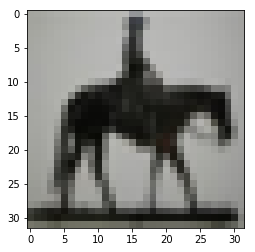

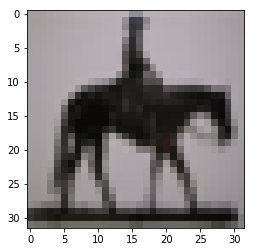

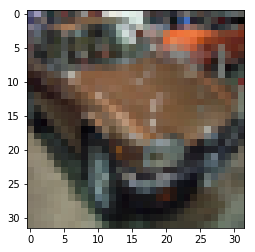

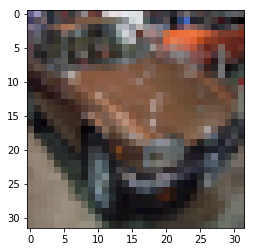

In [21]:
# Show some of the images
plt.imshow(test[0][288].reshape((32,32,3)), cmap = "gray")
plt.show()
plt.imshow(test_t[288].reshape((32,32,3)), cmap = "gray")
plt.show()
plt.imshow(test[0][2000].reshape((32,32,3)), cmap = "gray")
plt.show()
plt.imshow(test_t[2000].reshape((32,32,3)), cmap = "gray")
plt.show()

# Convolution layer with relu

In [23]:
def conv_relu_layer(input,filter_size=[3,3],num_features=[1]):

    # Get number of input features from input and add to shape of new layer
    shape=filter_size+[input.get_shape().as_list()[-1],num_features]
    W = tf.get_variable('W',shape=shape) # Default initialization is Glorot (the one explained in the slides)
    b = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer) 
    conv = tf.nn.conv2d(input, W, strides=[1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(conv + b)
    return(relu)

# Fully connected layer

In [24]:
def fully_connected_layer(input,num_features):
    # Make sure input is flattened.
    flat_dim=np.int32(np.array(input.get_shape().as_list())[1:].prod())
    input_flattened = tf.reshape(input, shape=[-1,flat_dim])
    shape=[flat_dim,num_features]
    W_fc = tf.get_variable('W',shape=shape) 
    b_fc = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer)
    fc = tf.matmul(input_flattened, W_fc) + b_fc
    return(fc)

# Plot Convolutional Layer

In [25]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = sess.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# The network

In [26]:
# Original Network

def create_network():
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=32)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=128)
            fc1r=tf.nn.relu(fc1)
            
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

In [32]:
# Deeper network with 4 convolutional layers and 3 fully connected layers

#tf.reset_default_graph()
def create_network_deeper_conv():
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=16)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=16)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv3"):
            # Variables created here will be named "conv3/weights", "conv3/biases".
            relu3 = conv_relu_layer(pool2, filter_size=[5, 5],num_features=32)
            pool3 = tf.nn.max_pool(relu3, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv4"):
            # Variables created here will be named "conv4/weights", "conv4/biases".
            relu4 = conv_relu_layer(pool3, filter_size=[5, 5],num_features=32)
            pool4 = tf.nn.max_pool(relu4, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool4,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=128)
            fc1r=tf.nn.relu(fc1)
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=128)
            fc2r=tf.nn.relu(fc2)
            
    with tf.variable_scope("fc3"):
            fc3 = fully_connected_layer(fc2r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc3 = tf.identity(fc3, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc3),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc3, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc3

In [34]:
# Deeper network with 2 convolutional layers and 3 fully connected layers

def create_network_deeper_fc():
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=32)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=128)
            fc1r=tf.nn.relu(fc1)
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=128)
            fc2r=tf.nn.relu(fc2)
            
    with tf.variable_scope("fc3"):
            fc3 = fully_connected_layer(fc2r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc3 = tf.identity(fc3, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc3),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc3, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc3

# Get loss and accuracy on a data set with output from final layer fc2

In [28]:
from scipy.special import logsumexp

def get_stats(data,labels):
    t1=time.time()
    lo=0.
    acc=0.
    delta=1000
    rr=np.arange(0,data.shape[0],delta)
    for i in rr:
        fc2_out=fc2.eval(feed_dict={x: data[i:i+delta], y_:labels[i:i+delta]})
        log_sf=logsumexp(fc2_out,axis=1).reshape((fc2_out.shape[0],1))-fc2_out
        lo+=np.mean(np.sum(labels[i:i+delta]*log_sf, axis=1))
        acc += np.mean(np.equal(np.argmax(fc2_out, axis=1),np.argmax(labels[i:i+delta], axis=1)))
    acc=acc/np.float32(len(rr))
    lo=lo/np.float32(len(rr))
    print('get stats time',time.time()-t1)
    # We return the final functions (they contain all the information about the graph of the network)
    return lo, acc

# Run one epoch

In [29]:

# Run the iterations of one epoch
def run_epoch(train,val,ii,batch_size,train_step_new):
        t1=time.time()
        # Randomly shuffle the training data
        np.random.shuffle(ii)
        tr=train[0][ii]
        y=train[1][ii]
        lo=0.
        acc=0.
        # Run disjoint batches on shuffled data
        for j in np.arange(0,len(y),batch_size):
            if (np.mod(j,5000)==0):
                print('Batch',j/batch_size)
            batch=(tr[j:j+batch_size],y[j:j+batch_size])
            train_step_new.run(feed_dict={x: batch[0], y_: batch[1], lr_: step_size,keep_prob_:keep_prob})
        print('Epoch time',time.time()-t1)

In [30]:
def get_data(data_set):
    if (data_set=="cifar"):
        return(get_cifar())
    elif (data_set=="mnist"):
        return(get_mnist())
    elif (data_set=="mnist_transform"):
        return(get_mnist_trans())

# Run the training. Save the model and test at the end¶

conv1/W:0 [5, 5, 3, 32] 0.048274435
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.028868083
conv2/b:0 [64] 0.0
fc1/W:0 [4096, 128] 0.021739222
fc1/b:0 [128] 0.0
fc2/W:0 [128, 10] 0.12066748
fc2/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 1.0658066272735596
get stats time 0.3088865280151367
Epoch 0 Train loss, accuracy 1.8802871941208839 0.3193
get stats time 0.14475083351135254
EPoch 0 Validation loss, accuracy 1.8996543235778809 0.3096
Batch 0.0
Batch 10.0
Epoch time 0.8767569065093994
Batch 0.0
Batch 10.0
Epoch time 0.8716697692871094
get stats time 0.2954695224761963
Epoch 2 Train loss, accuracy 1.5542919852972028 0.43950000000000006
get stats time 0.14523744583129883
EPoch 2 Validation loss, accuracy 1.5803681525707245 0.43879999999999997
Batch 0.0
Batch 10.0
Epoch time 0.8739995956420898
Batch 0.0
Batch 10.0
Epoch time 0.8889603614807129
get stats time 0.29581379890441895
Epoch 4 Train loss, accuracy 1.3736034821271896 0.5136
get stats time 0.14615130424499512
EPoch 4 Validation 

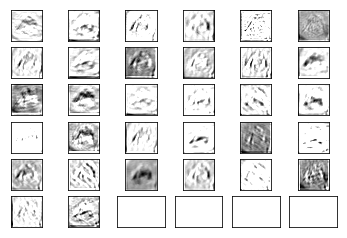

Model saved in path: tmp/model


In [40]:
# Run the training

# Currently the original model is run on the training and validation model, tested on the modified images.
# Firt convolutional layers printed out in the output.

import time
batch_size=500
step_size=.001
num_epochs=40
num_train=10000
minimizer="Adam"
data_set="cifar"
model_name="model"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3

err_rate_train = []
err_rate_val = []

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

with tf.Session() as sess:
        train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =create_network()

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                # Test set accuracy
                #err_rate_trainval.append(((1-ac)*num_train + (1-vac)*10000)/(num_train+10000))
                err_rate_train.append(1-ac)
                err_rate_val.append(1-vac)
                
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test_t, y_:test[1]}))
        
        image = train[0][0]
        #image = tf.reshape(train[0][0], [-1, dim, dim, nchannels])
        conv = tf.nn.conv2d(x_image, tf.trainable_variables()[0], strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(conv + tf.trainable_variables()[1])
        plot_conv_layer(relu, image)
        
        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)


## (c) Deeper network with the same number of parameters (d) Variability. Analysis

Original Network:
    - Test Accuracy: 0.5816 (20 epoch)
    - Test Accuracy: 0.5795 (40 epoch)
    - Modified images:
        - Test Accuracy: 0.5671 (20 epoch)
        - Test Accuracy: 0.5947 (40 epoch)
Deeper Network (with more convolutional layers and more fully connected layers):
    - Test Accuracy: 0.473 (20 epoch)
    - Modified images:
        - Test Accuracy: 0.483 (20 epoch)
Deeper Network (with more fully connected layers ONLY):
    - Test Accuracy: 0.5664 (20 epoch)
    - Test Accuracy: 0.5844 (40 epoch)
    - Modified images:
        - Test Accuracy: 0.5855 (20 epoch)
        - Test Accuracy: 0.6007 (40 epoch)
        
Analysis: 
- Adding more convolutional layers actually decrease the test accuracy. This might be due to that more layers of features detection result in information loss.
- However, keeping the same number of convolutional layers but only increasing the fully connected layers restore the accuracy on the test images. Higher accuracy gotten then the original model when 40 epochs were run.
- As can be seen in the first convolutional layer printed out, with less features in the first layer, each filtered image capture the specific feature worse and the features are not good enough to distinguish each other. 
- Testing on the modified images gives interesting result. Test accuracy is a little bit below the original images on original model when 20 epochs were run but performed better on other two deeper networks. With 40 epochs run, all three models perform better on the modified images test set. This might tell us that the deeper model can handle vairiability better than the shallow networks.

## (b) Plot training and validation error against epoch number. First convolutional layer shown above in the output.

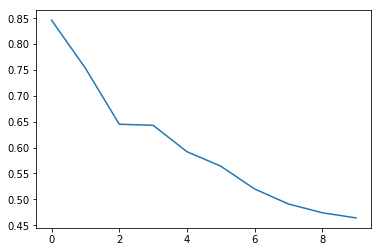

In [15]:
# Plot training error against epoch number. 20 epochs in total.
plt.plot(err_rate_train)

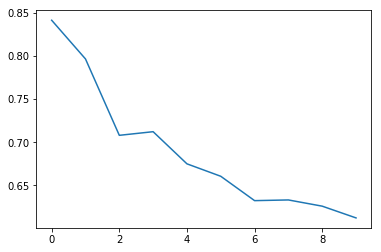

In [16]:
# Plot validation error against epoch number. 20 epochs in total.
plt.plot(err_rate_val)

# Reload the model that was saved and continue training

In [ ]:
# Reloading an existing model.

tf.reset_default_graph()
batch_size=500
step_size=.001
num_epochs=4
num_train=10000
data_set="mnist"
model_name="model"
Train=True
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3
    
with tf.Session() as sess:
    # Get data
    train, val, test=get_data(data_set=data_set)
    # Load model info
    saver = tf.train.import_meta_graph('tmp/'+model_name+'.meta')
    saver.restore(sess,'tmp/'+model_name) 
    graph = tf.get_default_graph()
    # Setup the placeholders from the stored model.
    x = graph.get_tensor_by_name('x:0')
    y_= graph.get_tensor_by_name('y:0')
    lr_ = graph.get_tensor_by_name('learning_rate:0')
    keep_prob_ = graph.get_tensor_by_name('keep_prob:0')
    accuracy=graph.get_tensor_by_name('helpers/ACC:0')
    cross_entropy=graph.get_tensor_by_name('cross_entropy_loss/LOSS:0')
    fc2=graph.get_tensor_by_name('OUT:0')
    # Get the minimization operation from the stored model
    if (Train):
        train_step_new = tf.get_collection("optimizer")[0]
        # Confirm training accuracy of current model before additional training
        acc=accuracy.eval(feed_dict={x: train[0][0:num_train], y_:train[1][0:num_train]})
        print('train acc',acc)

        ii=np.arange(0,num_train,1) 
        for i in range(num_epochs):  # Run epochs
            run_epoch(train,val,ii,batch_size,train_step_new)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
    # Test set accuracy

    print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))
    
    tf.add_to_collection("optimizer", train_step)
    saver = tf.train.Saver()
    save_path = saver.save(sess, "tmp/"+model_name)
    print("Model saved in path: %s" % save_path)